In [77]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Downloading the dataset

The kaggle challange can be [accessed  here](https://www.kaggle.com/competitions/isic-2024-challenge/overview). \
The dataset is a set of RGB images with varying dimentions. The images are labeled whether they depict skin cancer. Additional metadata is also provided (e.g. age, sex, etc. of the patient)


Run the cell below to download the files from Google Drive, where we are already uploaded it.

In [78]:
import zipfile
!pip install gdown
import gdown

def download_data():
    if(not Path("data").exists()):
        
    # extract zip to the data dir
        gdown.download("https://drive.google.com/uc?id=13z3O9BI082DFGs8aSaCAzWDbYCs_ZLxT", "resources.zip", quiet=False)
        with zipfile.ZipFile("resources.zip", 'r') as zip_ref:
            zip_ref.extractall("data")


[notice] A new release of pip is available: 24.1.2 -> 24.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [79]:
download_data()

## Loading the data

Loading the images, corresponding metadata and obtaining the labels

In [80]:
DATASET_HOME = Path.cwd() /  "data" 
TRAIN_IMAGES_PATH = DATASET_HOME / "train-image" / "image"
METADATA_PATH = DATASET_HOME / "train-metadata.csv"

image_iterator = TRAIN_IMAGES_PATH.glob("*")
image_count = len(list(image_iterator))
print("The dataset contains {} images".format(image_count))

The dataset contains 401059 images


In [81]:
# Read the metadata, which contains the labels
pd.set_option('display.max_columns', None)

df = pd.read_csv(METADATA_PATH)
df = df[
    [
        'isic_id',
        'target',
        'age_approx', 
        'sex', 
        'tbp_lv_areaMM2', 
        'tbp_lv_area_perim_ratio', 
        'tbp_lv_color_std_mean', 
        'tbp_lv_deltaLBnorm', 
        'tbp_lv_location', 
        'tbp_lv_minorAxisMM', 
        'tbp_lv_nevi_confidence', 
        'tbp_lv_norm_border', 
        'tbp_lv_norm_color', 
        'tbp_lv_perimeterMM', 
        'tbp_lv_radial_color_std_max', 
        'tbp_lv_symm_2axis', 
        'tbp_lv_symm_2axis_angle'
    ]
]

df.head()

/tmp/ipykernel_239/2471693436.py:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(METADATA_PATH)


,isic_id,target,age_approx,sex,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaLBnorm,tbp_lv_location,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle
0,ISIC_0015670,0,60.0,male,3.152561,27.476170,0.00000,5.784302,Right Leg - Upper,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,0.590476,85
1,ISIC_0015845,0,60.0,male,0.919497,12.235290,0.00000,4.987244,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.285714,55
2,ISIC_0015864,0,60.0,male,3.265153,24.184620,0.00000,6.290359,Torso Back Top Third,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,0.361905,105
3,ISIC_0015902,0,65.0,male,6.079940,14.889242,0.51452,6.400196,Torso Front Top Half,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,0.209581,130
4,ISIC_0024200,0,55.0,male,2.101708,19.902560,0.00000,6.531302,Torso Front Top Half,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,0.313433,20


In [82]:
df.drop(columns=["isic_id","target"]).describe()

,age_approx,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaLBnorm,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle
count,398261.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000
mean,58.012986,8.539975,19.084517,1.070408,7.538922,2.539773,38.520265,3.451523,3.091590,11.878891,1.016459,0.306823,86.332073
std,13.596165,9.679312,5.357863,0.762918,2.404951,1.173169,41.480936,1.724557,2.044813,5.919302,0.734631,0.125038,52.559511
min,5.000000,0.431601,10.761634,0.000000,3.001138,0.273973,0.000000,0.589426,0.000000,2.579237,0.000000,0.052034,0.000000
25%,50.000000,4.109589,15.426205,0.574909,5.748160,1.812707,0.109819,2.143836,1.728774,8.338364,0.563891,0.211429,40.000000
50%,60.000000,5.685870,17.423950,0.931402,6.946320,2.265201,14.408514,2.996933,2.764664,10.015440,0.902281,0.282297,90.000000
75%,70.000000,9.119910,21.011340,1.412154,8.748403,2.905918,87.791395,4.358399,4.120246,13.209100,1.334523,0.382022,130.000000
max,85.000000,334.152700,87.205340,9.952932,30.487456,18.387900,100.000000,10.000000,10.000000,102.493900,11.491140,0.977055,175.000000


In [83]:
from itertools import islice

# Uncomment the multiplication to only load a small portion of the dataset for experimentation
load_count = int(image_count * 0.001)
print("Number of images to be loaded {}".format(load_count))

X = []
metadata = []
for file_path in islice(TRAIN_IMAGES_PATH.glob("*"), 0, load_count):
    filename = file_path.with_suffix("").name
    row = df.loc[df["isic_id"] == filename]
    metadata.append(row)
    with Image.open(file_path) as im:
        X.append(Image.open(file_path))

Y = [row["target"] for row in metadata]

Number of images to be loaded 401


### Show example of a negative and a positive sample

Text(0.5, 1.0, 'Benign')

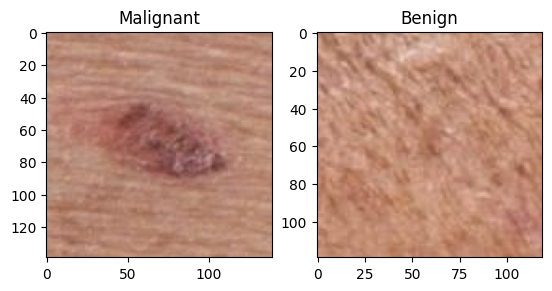

In [84]:
malignant_idx = next(i for i,v in enumerate(Y) if v.item() == 1)
malignant = X[malignant_idx]
benign_idx = next(i for i,v in enumerate(Y) if v.item() == 0)
benign = X[benign_idx]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(malignant)
ax[0].set_title("Malignant")

ax[1].imshow(benign)
ax[1].set_title("Benign")

## Preprocessing

* Scaling the images and metadata
* Creating the train-test splits

#### Image preprocessing
Not all images are of the same dimentionality. The most straight-forward solution is to rescale the images to match the most frequent dimentions. \
This solution shouldn't significantly worsen the performance of the models as long as all the images are n by n sized

In [85]:
sizes = [im.size for im in X]
not_square = list(filter(lambda s: s[0] != s[1] ,sizes))
print(f"{len(not_square)} images are not n by n.")

values, counts = np.unique(sizes, return_counts=True)
most_frequent = values[np.argmax(counts)]
print(f"Most frequent size: {most_frequent}")

0 images are not n by n.
Most frequent size: 125


In [86]:
scaled_images = [im.resize([most_frequent, most_frequent]) for im in X]
# Maping to a np array and scaling the images to the [0,1] interval
X_scaled = np.array(scaled_images) / 255
X_scaled.shape

(401, 125, 125, 3)

#### Metadata preprocessing

To preprocess metadata, apply appropriate scalers, convert binary fields to numeric format, and one-hot encode fields with multiple categorical options. Then, combine all preprocessed data and convert it to a compatible NumPy array for modeling. 

In [87]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
z_score_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

X_meta_z_scaled =  z_score_scaler.fit_transform(df[[
        'age_approx', 
        'tbp_lv_areaMM2', 
        'tbp_lv_area_perim_ratio', 
        'tbp_lv_color_std_mean', 
        'tbp_lv_deltaLBnorm', 
        'tbp_lv_minorAxisMM', 
        'tbp_lv_nevi_confidence', 
        'tbp_lv_norm_border', 
        'tbp_lv_norm_color', 
        'tbp_lv_perimeterMM', 
        'tbp_lv_radial_color_std_max', 
        'tbp_lv_symm_2axis', 
        'tbp_lv_symm_2axis_angle'
    ]])


#X_meta_min_max_scaled = min_max_scaler.fit_transform(df[[]])


X_meta_binary = pd.get_dummies(df[[
    'sex'
    ]], drop_first=True)

X_mate_multi = pd.get_dummies(df[[
    'tbp_lv_location'
    ]], drop_first=True)

X_meta_= np.hstack([X_meta_z_scaled, X_meta_min_max_scaled, X_meta_binary, X_mate_multi])

X_meta_[0].shape

(51,)

#### Train - Test split

In [88]:
from sklearn.model_selection import train_test_split

test_size=0.3

# Validation split to be handled by the model
# No need to specify validation split here, we will be able to do it inside the learning model
X_train, X_test, meta_train, meta_test, Y_train, Y_test = train_test_split(X_scaled, metadata, Y, test_size=test_size,shuffle=True, random_state=42)
print(f"Training dataset: {X_train.shape[0]}\nTest dataset: {X_test.shape[0]}")

Training dataset: 280
Test dataset: 121


       age_approx   sex
10207        35.0  male
Benign


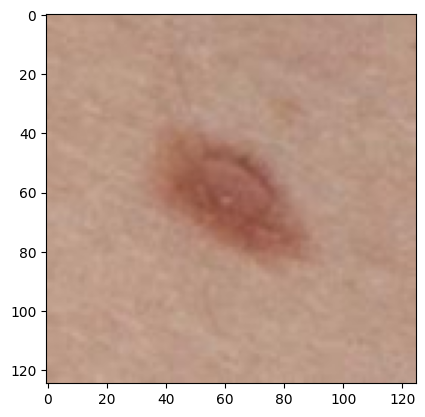

In [89]:
# Inspect a random training instance

random_idx = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[random_idx])
print(meta_train[random_idx][["age_approx", "sex"]])  # TODO: Find other useful columns
print("Malignant" if Y[random_idx].item() else "Benign")